<a href="https://colab.research.google.com/github/aravindchakravarti/Deep_Learning_EVA_4/blob/master/S5_MNIST_Optimum_Parameter/EVA4_Session_5_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Target
* Must hit 99.4% accuracy atleast 3 times in 15 epochs
* Should I really use 1x1 kernel? May not be, because we have like 10-14 channels in first block. May not be required.
* Use learning rate schedular

## Result
* Achieved 99.4 in 1 epoch! (12th epoch)
* Parameters = 9.3k parameters

## Analysis
* Readuced the learning rate to 0.005 with StepLR of gamma 0.5/10 epochs
* Reduced (almost removed the dropout) - Why? We are using the augmentations. So, dropout may not do much help.
* Removed 1x1 kernel at this moment. Why?- Because have about 10-14 channels in first block. 1x1 may not help too much. 


## Code is available at:
https://colab.research.google.com/drive/1VrXTDA58W8JtBhCtvCv_S08YwT-Jj6Rl



# Import Libraries

In [0]:
from __future__ import print_function
import torch
# Import core module
import torch.nn as nn
# We need support for functional programming
import torch.nn.functional as F
import torch.optim as optim
# For MNIST dataset
from torchvision import datasets, transforms
# For Global Average Pooling
from torch.nn import AvgPool2d
# Plotting purpose
%matplotlib inline
import matplotlib.pyplot as plt

# Data Transformations
We first start with defining our data transformations. Image augmentation techniques are great and we need to keep it ready by the time we hit overfitting!

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train and Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders

In [25]:
# SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
# torch.manual_seed(SEED)

#if cuda:
#    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The Model

I like the model definition like below, not with nn.Sequential() way. So, I am going to keep it same 

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv01 = nn.Conv2d(1, 6, 3, bias=False, padding=1)        #O=28
        self.batch01 = nn.BatchNorm2d(num_features=6)    
        self.conv02 = nn.Conv2d(6, 8, 3, bias=False,padding=1)        #O=28
        self.batch02 = nn.BatchNorm2d(num_features=8)    
        self.conv03 = nn.Conv2d(8, 10, 3, bias=False,padding=1)        #O=28
        self.batch03 = nn.BatchNorm2d(num_features=10)   
        self.conv04 = nn.Conv2d(10, 10, 3, bias=False,padding=0)        #O=26
        self.batch04 = nn.BatchNorm2d(num_features=10)   
        self.pool01 = nn.MaxPool2d(2, 2)                                #O=13
       # self.conv05 = nn.Conv2d(12, 10, 1, bias=False)

        self.conv11 = nn.Conv2d(10, 10, 3, bias=False, padding=1)       #O=13
        self.batch11 = nn.BatchNorm2d(num_features=10)
        self.conv12 = nn.Conv2d(10, 10, 3, bias=False, padding=0)       #O=11
        self.batch12 = nn.BatchNorm2d(num_features=10)
        self.conv13 = nn.Conv2d(10, 14, 3, bias=False, padding=0)       #O=09
        self.batch13 = nn.BatchNorm2d(num_features=14)
        self.conv14 = nn.Conv2d(14, 14, 3, bias=False, padding=0)       #O=07
        self.batch14 = nn.BatchNorm2d(num_features=14)
        self.conv15 = nn.Conv2d(14, 16, 3, bias=False, padding=0)       #O=05
        self.batch15 = nn.BatchNorm2d(num_features=16)
    
        self.avg_pool = nn.AvgPool2d(kernel_size=5)
        self.conv23 = nn.Conv2d(16, 10, 1, bias=False, padding=0)

    def forward(self, x):
        x = self.batch01(F.dropout(F.relu(self.conv01(x)), 0.01))        
        x = self.batch02(F.dropout(F.relu(self.conv02(x)), 0.01))
        x = self.batch03(F.dropout(F.relu(self.conv03(x)), 0.01))
        x = self.batch04(F.dropout(F.relu(self.conv04(x)), 0.01))
        x = self.pool01(x)
        #x = F.relu(self.conv05(x))

        x = self.batch11(F.dropout(F.relu(self.conv11(x)), 0.02))
        x = self.batch12(F.dropout(F.relu(self.conv12(x)), 0.02))
        x = self.batch13(F.dropout(F.relu(self.conv13(x)), 0.02))
        x = self.batch14(F.dropout(F.relu(self.conv14(x)), 0.02))
        x = self.batch15(F.dropout(F.relu(self.conv15(x)), 0.02))

        x = self.avg_pool(x)
        x = F.relu(self.conv23(x))
        x = x.view(-1, 10)                           # Don't want 10x1x1..
        return F.log_softmax(x)

# Model Parameters and other details

In [37]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]              54
       BatchNorm2d-2            [-1, 6, 28, 28]              12
            Conv2d-3            [-1, 8, 28, 28]             432
       BatchNorm2d-4            [-1, 8, 28, 28]              16
            Conv2d-5           [-1, 10, 28, 28]             720
       BatchNorm2d-6           [-1, 10, 28, 28]              20
            Conv2d-7           [-1, 10, 26, 26]             900
       BatchNorm2d-8           [-1, 10, 26, 26]              20
         MaxPool2d-9           [-1, 10, 13, 13]               0
           Conv2d-10           [-1, 10, 13, 13]             900
      BatchNorm2d-11           [-1, 10, 13, 13]              20
           Conv2d-12           [-1, 10, 11, 11]             900
      BatchNorm2d-13           [-1, 10, 11, 11]              20
           Conv2d-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# Training and Testing

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Train the model

In [39]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.1898258924484253 Batch_id=468 Accuracy=80.54: 100%|██████████| 469/469 [00:13<00:00, 33.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1336, Accuracy: 9694/10000 (96.94%)

EPOCH: 1


Loss=0.04342438653111458 Batch_id=468 Accuracy=97.27: 100%|██████████| 469/469 [00:13<00:00, 35.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0709, Accuracy: 9810/10000 (98.10%)

EPOCH: 2


Loss=0.06413894146680832 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:12<00:00, 36.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Accuracy: 9869/10000 (98.69%)

EPOCH: 3


Loss=0.12149391323328018 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:12<00:00, 37.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Accuracy: 9882/10000 (98.82%)

EPOCH: 4


Loss=0.08135469257831573 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:13<00:00, 39.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 9910/10000 (99.10%)

EPOCH: 5


Loss=0.05713222548365593 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:13<00:00, 34.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9900/10000 (99.00%)

EPOCH: 6


Loss=0.025448882952332497 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:12<00:00, 36.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9916/10000 (99.16%)

EPOCH: 7


Loss=0.03899087384343147 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:13<00:00, 36.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9908/10000 (99.08%)

EPOCH: 8


Loss=0.035382229834795 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:13<00:00, 35.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9926/10000 (99.26%)

EPOCH: 9


Loss=0.022387171164155006 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:13<00:00, 35.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.007785057183355093 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:12<00:00, 36.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9934/10000 (99.34%)

EPOCH: 11


Loss=0.03047209419310093 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:12<00:00, 36.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9939/10000 (99.39%)

EPOCH: 12


Loss=0.0037582218647003174 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 41.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9942/10000 (99.42%)

EPOCH: 13


Loss=0.05491997301578522 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 40.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9929/10000 (99.29%)

EPOCH: 14


Loss=0.05059514567255974 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:12<00:00, 42.68it/s]



Test set: Average loss: 0.0229, Accuracy: 9931/10000 (99.31%)



# Most important part - Plots


Text(0.5, 1.0, 'Test Accuracy')

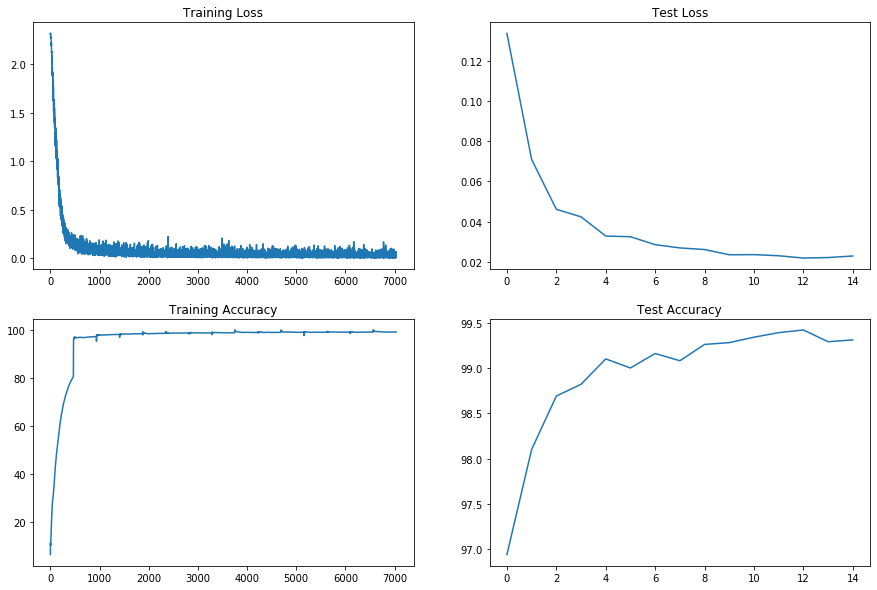

In [40]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")